#MNIST 데이터

##개요
- 손글씨 데이터
- 손으로 작성된 0~9까지의 숫자 이미지
- 이미지 + Label(Y=Target) = 하나의 데이터셋

##이미지 속성
- 차원 : (가로,세로,색조)=(28,28,1), 픽셀값(밝기에 따라) : 0~255

##레이블 정보
- 단순 스칼라 : (확률정보이용)-One hot encoding

##해결전략
1. 이미지, Label 전처리
2. Neural network 모델 생성
3. Backpropagation 알고리즘 최적화
4. Test data 검증

# 이미지 전처리과정
- 이미지 전처리
 - 텐서 랭크변환 (28,28,1) -> (28*28) : 784차원 벡터
 - 이미지 픽셀 정규화 (0 ~ 255) -> (0 ~ 1)

- Torch 코드
 - 랭크변환 X = X.view(-1.784)
 - 픽셀 정규화 X /= torch.max(X) 

- 레이블 처리
 - 원-핫 인코딩(One-hot encording) -> 확률분포도로 변환작업
  
  ex) MNIST 레이블 : 10개의 숫자를 10개의 사건분포로

5 -> One hot encording

__X : 0 1 2 3 4 5 6 7 8 9 

P(X): 0 0 0 0 0 1 0 0 0 0

=> 5 = [0,0,0,0,0,1,0,0,0,0]


- 프로세스
 1. Neural network 초기 생성

   Layer 구성 (784->256->128->10)
   
   Activation(...........Relu...Relu...Softmax)

 2. Loss함수 (KL-divergence)

    + Softmax(모든 벡터의 값 0~1),   
$ softmax(X) = \frac{e^{X}}{Σ e^{X}} $




In [58]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as opt
import torchvision.datasets as dataset #torchvision : 이미지인식용
import torchvision.transforms as transforms # 가공 + 텐서로 변환

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [59]:
# 데이터 셋 다운로드, 코랩에 있는 데이터들의 상태가 좋지않아 토치비전에서 다운받는다고 함
mn_train = dataset.MNIST(root='MNIST_data/',
                         train=True,
                         transform=transforms.ToTensor(),
                         download=True) # MNIST_train -> 60000개 (image,label)

mn_test = dataset.MNIST(root='MNIST_data/',
                         train=False,
                         transform=transforms.ToTensor(),
                         download=True) # MNIST_test -> 10000개 (image,label)


Dataset MNIST
    Number of datapoints: 60000
    Root location: MNIST_data/
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset MNIST
    Number of datapoints: 10000
    Root location: MNIST_data/
    Split: Test
    StandardTransform
Transform: ToTensor()
5


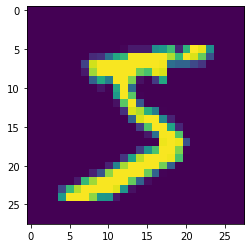

In [60]:
#데이터 정보 프린트
print(mn_train)
print(mn_test)

#sample
img, label = mn_train[0]
plt.imshow(img[0,:,:])
print(label)

In [61]:
# 상대적으로 쉬운 문제이므로 vaild_dataset은 따로 상정하지 않음?
train_loader = torch.utils.data.DataLoader(mn_train,batch_size=32,shuffle=True,drop_last=False)
test_loader = torch.utils.data.DataLoader(mn_test,batch_size=32,shuffle=False,drop_last=False)

In [62]:
# NN 모델만들기
class MNIST_full(nn.Module):
  def __init__(self):
    super(MNIST_full,self).__init__()
    self.lin1 = nn.Linear(784,256)
    self.lin2 = nn.Linear(256,128)
    self.lin3 = nn.Linear(128,10)

  def forward(self,x):
    x = x.view(-1,784) #(batch,28,28,1)-->(batch,784)
    x = F.relu(self.lin1(x))
    x = F.relu(self.lin2(x))
    x = F.softmax(self.lin3(x),dim=1) 
    return x 

In [63]:
model = MNIST_full()
optimizer = opt.Adam(model.parameters(),lr=0.0001)

In [64]:
def kl_div(prob1,prob2):
  return torch.sum(prob1*torch.log(prob1/prob2+1e-15))

In [65]:
#train 단계
#criterion = nn.CrossEntropyLoss() 어차피 안됨ㅋㅋ, kl_div 경량화된 확률간 거리구하는 공식(유틸?
for epoch in range(10):
  loss_buffer = []
  for x,y in train_loader: # x는 이미지, y는 레이블
    optimizer.zero_grad()

    y_onehot = torch.zeros((y.shape[0],10))
    y_onehot[range(y.shape[0]),y]=1  #__ 이 두줄이 one_hot encording
    y_infer = model(x)
    #loss = criterion(y_infer,y) 이것도 않됌ㅋㅋ
    loss = kl_div(y_onehot,y_infer) # kl_div 확률간 거리 (레이블, 추론)
    loss.backward() #grad 획득
    optimizer.step() # Gradient desent 수행
    loss_buffer.append(loss.item())

  print('Epoch: {:d}. Train loss {:f}'.format(epoch,np.mean(loss_buffer)))

Epoch: 0. Train loss 17.673709
Epoch: 1. Train loss 7.996463
Epoch: 2. Train loss 6.360030
Epoch: 3. Train loss 5.254107
Epoch: 4. Train loss 4.418347
Epoch: 5. Train loss 3.789400
Epoch: 6. Train loss 3.286167
Epoch: 7. Train loss 2.873786
Epoch: 8. Train loss 2.539206
Epoch: 9. Train loss 2.256276


In [53]:
#Test 단계
acc=[] #정확도 계산을 위한 버퍼
for x,y in test_loader:
  # one_hot encording
  y_onehot = torch.zeros((len(y),10))
  y_onehot[range(len(y)),y] = 1
  y_infer = model(x)

  #정확도 계산
  correct_prediction = torch.argmax(y_infer, 1) == y #argmax(y_infer, 1) == 1에 해당하는 인덱스 출력]
  acc.append(correct_prediction.float().mean())

print('Test loss {:f}, Accuracy {:f}'.format(np.mean(loss_buffer),np.mean(acc)))

Test loss 0.646076, Accuracy 0.977736


실제 이미지 숫자 7
예측 이미지 숫자 tensor([7])


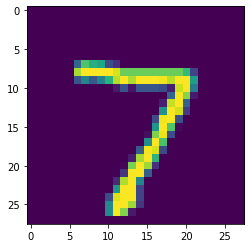

In [56]:
# 실물샘플
img, label=mn_test[0]
plt.imshow(img[0,:,:])
y_infer = model(img)
print('실제 이미지 숫자',label)
print('예측 이미지 숫자',torch.argmax(y_infer,1))

In [57]:
print(y_infer)

tensor([[4.4812e-08, 4.2518e-08, 5.1321e-06, 3.6087e-05, 1.8752e-10, 1.9532e-08,
         5.0119e-15, 9.9995e-01, 5.9706e-07, 6.1828e-06]],
       grad_fn=<SoftmaxBackward0>)


In [ ]:
#과제